# Импорт библиотек

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Загрузка и обзор данных

In [20]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

test_ids = test["id"]

In [21]:
print("Размер train:", train.shape)
print("Размер test:", test.shape)
train.sample(10)

Размер train: (165034, 14)
Размер test: (110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
159841,159841,15641621,Chibueze,827,France,Male,38.0,3,132452.96,1,1.0,1.0,176713.47,0
93196,93196,15645095,Huang,674,France,Female,37.0,3,0.00,2,1.0,0.0,51536.99,0
71552,71552,15576714,Manna,687,Spain,Female,21.0,8,0.00,2,1.0,0.0,154767.34,0
152355,152355,15646726,Onwubiko,705,France,Male,44.0,6,0.00,2,1.0,0.0,81622.52,0
1201,1201,15658475,Lori,834,France,Male,34.0,8,0.00,2,1.0,0.0,72969.90,0
115743,115743,15652910,Onyinyechukwuka,751,France,Female,35.0,0,0.00,1,1.0,1.0,123866.77,0
100473,100473,15645025,Lucchese,707,Germany,Male,33.0,2,133853.23,1,1.0,0.0,90106.94,0
59273,59273,15791501,T'ang,596,France,Female,34.0,8,131287.36,1,1.0,0.0,120790.02,0
126864,126864,15659937,Otutodilinna,703,France,Female,40.0,7,0.00,1,0.0,1.0,122518.50,0
108987,108987,15791778,Yevdokimova,709,Spain,Male,39.0,5,125537.43,1,0.0,0.0,118528.73,0


In [22]:
print("Общая информация о данных:")
train.info()

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [23]:
print("\nОписательная статистика (числовые):")
display(train.describe())
print("\nОписательная статистика (категориальные):")
display(train.describe(include='object'))


Описательная статистика (числовые):


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000



Описательная статистика (категориальные):


,Surname,Geography,Gender
count,165034,165034,165034
unique,2797,3,2
top,Hsia,France,Male
freq,2456,94215,93150


In [24]:
print("Количество дубликатов:", train.duplicated().sum())
print(f"\nКоличество уникальных значений в признаках:\n{train.nunique()}")

Количество дубликатов: 0

Количество уникальных значений в признаках:
id                 165034
CustomerId          23221
Surname              2797
CreditScore           457
Geography               3
Gender                  2
Age                    71
Tenure                 11
Balance             30075
NumOfProducts           4
HasCrCard               2
IsActiveMember          2
EstimatedSalary     55298
Exited                  2
dtype: int64


# EDA (Exploratory Data Analysis)

## Анализ целевого признака `Exited`

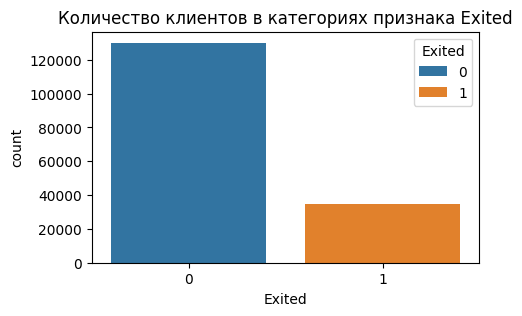

In [25]:
plt.figure(figsize=(5,3))
sns.countplot(data=train,x=train['Exited'],hue=train['Exited'])
plt.title("Количество клиентов в категориях признака Exited");

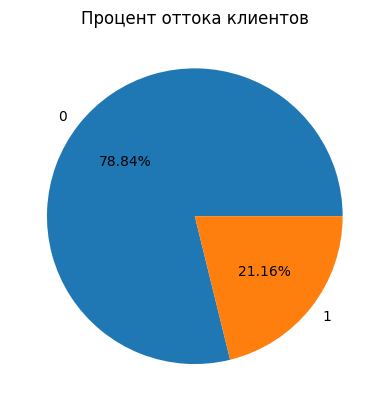

In [26]:
gb = train.groupby('Exited').agg({'Exited': 'count'})
plt.title('Процент оттока клиентов')
plt.pie(gb['Exited'],labels=gb.index,autopct='%1.2f%%');

Признак `Exited` отражает факт оттока клиента и используется как целевая переменная (бинарная классификация).  

- **Значения признака:**  
  - `0` — клиент остался в банке,  
  - `1` — клиент ушёл (отток).  

---

### Анализ распределения

- Распределение клиентов по `Exited` является **несбалансированным**: доля оставшихся (`0`) значительно превышает долю ушедших (`1`).  
- Ушедшие клиенты составляют около *20% выборки* (точная доля определяется при анализе данных), что создаёт проблему **классового дисбаланса**.  
- Такой дисбаланс может приводить к тому, что модель будет "склоняться" к предсказанию класса большинства (оставшихся), показывая высокую Accuracy, но низкий Recall для оттока.  

---

### Выводы

- Признак `Exited` задаёт задачу как **двоичную классификацию с несбалансированными классами**.  
- Для корректной оценки моделей необходимо использовать метрики, чувствительные к дисбалансу: **ROC-AUC, F1-score, Precision-Recall**.  
- При обучении рекомендуется применять балансировку классов .  
- Дисбаланс в целевой переменной также подчёркивает бизнес-проблему: **отток затрагивает меньшую часть клиентов, но имеет высокую значимость для банка**, так как каждый ушедший клиент несёт прямые потери.  

## Анализ признака `Age`

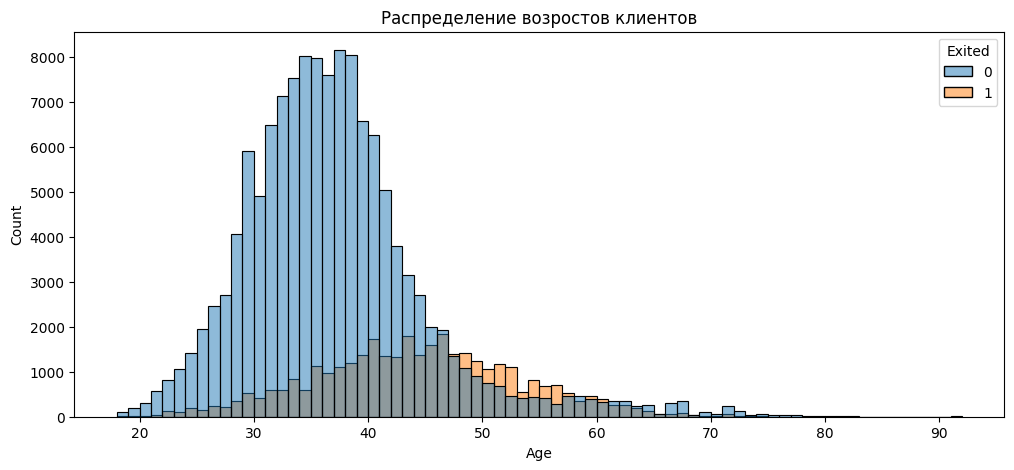

In [27]:
plt.figure(figsize=(12,5))
sns.histplot(data=train,x=train['Age'],bins=74, hue=train['Exited'])
plt.title('Распределение возростов клиентов');

На гистограмме показано распределение возрастов клиентов с разделением по целевому признаку `Exited` (0 — клиент остался, 1 — ушёл).

- Основная масса клиентов находится в возрасте **от 25 до 45 лет**.  
- Ушедшие клиенты (`Exited = 1`) заметно чаще встречаются **в возрастной группе 40–55 лет**.  
- В более молодом возрасте (до 30 лет) churn практически отсутствует, а после 60 лет количество клиентов резко снижается, и влияние становится менее значимым.  

**Вывод:** возраст является **сильным фактором риска оттока**. Особенно стоит обратить внимание на клиентов среднего возраста (40+), которые демонстрируют более высокую склонность к уходу.  

## Анализ признака `CreditScore`

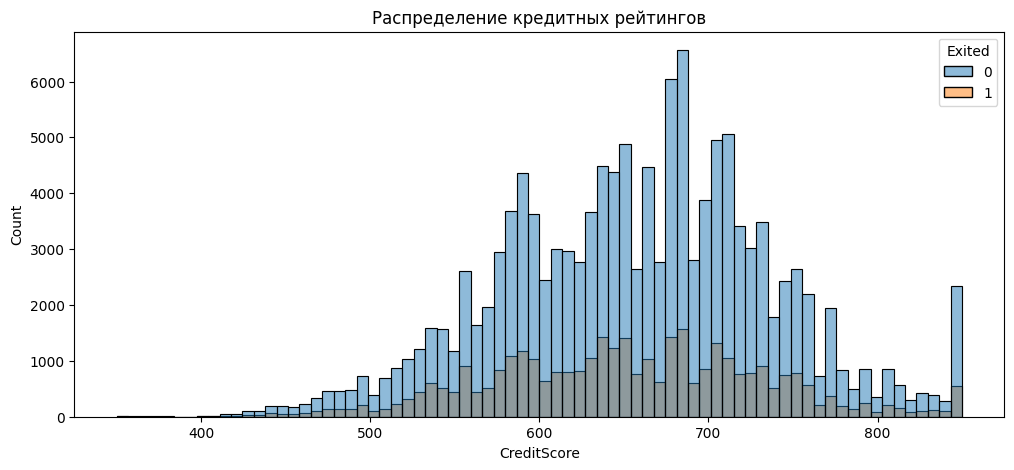

In [28]:
plt.figure(figsize=(12,5))
sns.histplot(data=train,x=train['CreditScore'],bins=74, hue=train['Exited'])
plt.title('Распределение кредитных рейтингов');

На гистограмме представлено распределение признака `CreditScore` с разделением по целевому признаку `Exited`.

- Основная масса клиентов имеет кредитный рейтинг в диапазоне **550–750**, что соответствует типичному распределению скорингов в банковских данных.  
- Ушедшие клиенты (`Exited = 1`) встречаются во всех диапазонах рейтингов, однако их доля относительно стабильна и не демонстрирует ярко выраженной зависимости от кредитного рейтинга.  
- Клиенты с низким рейтингом (<500) и очень высоким (>800) встречаются редко, и значимых паттернов оттока в этих группах не наблюдается.  

**Вывод:** кредитный рейтинг **не является сильным предиктором оттока**. Его влияние на решение клиента уйти минимально по сравнению с другими признаками (например, возраст или баланс).  

## Анализ признака `Geography`

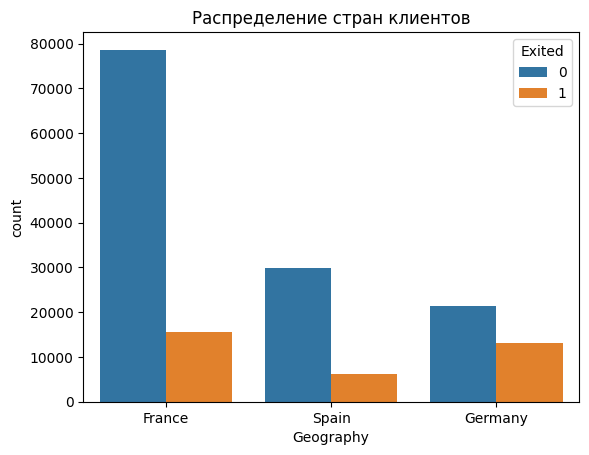

In [29]:
sns.countplot(data=train,x=train['Geography'],hue=train['Exited'])
plt.title('Распределение стран клиентов');

На графике показано распределение клиентов по странам с разделением на ушедших (Exited=1) и оставшихся (Exited=0).

- **France**: Наибольшее количество клиентов (≈78k не ушедших, ≈15k ушедших). Доля ушедших относительно всех клиентов во Франции составляет примерно **16%**.  
- **Spain**: Меньше клиентов, но доля ушедших схожа, около **17%**.  
- **Germany**: Общее количество клиентов меньше, но доля ушедших выше, примерно **38%**, что заметно выделяет Германию по риску оттока.

**Выводы:**
- География явно влияет на вероятность оттока: клиенты из Германии уходят чаще.
- При дальнейшей работе стоит учитывать баланс классов внутри каждой страны, так как доля ушедших сильно различается.

## Анализ признака `Gender`

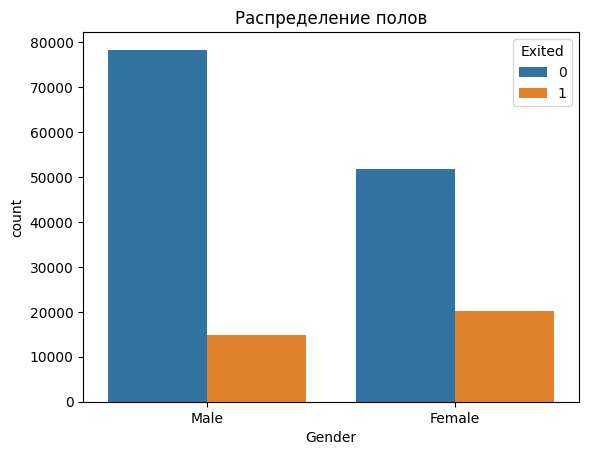

In [30]:
sns.countplot(data=train,x=train['Gender'],hue=train['Exited'])
plt.title('Распределение полов');

На графике показано распределение клиентов по полу с разделением на ушедших (Exited=1) и оставшихся (Exited=0).

- **Мужчины (Male)**: большинство клиентов (≈78k не ушедших и ≈14k ушедших). Доля ушедших составляет около **15%**.  
- **Женщины (Female)**: клиентов меньше (≈52k не ушедших и ≈20k ушедших), но доля оттока выше — примерно **28%**.  

**Выводы:**
- Женщины уходят значительно чаще, чем мужчины.  
- Признак `Gender` является информативным и должен использоваться в модели.

## Анализ признака `Tenure`

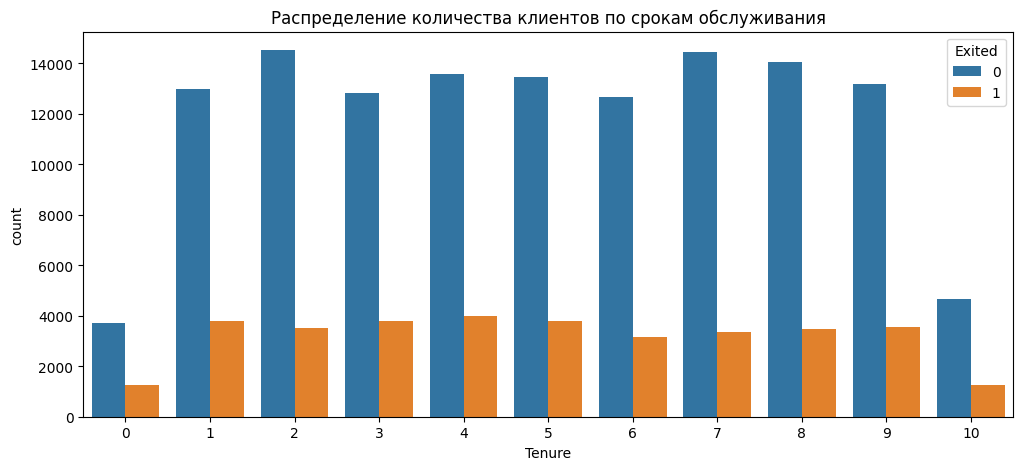

In [31]:
plt.figure(figsize=(12,5))
sns.countplot(x=train['Tenure'],data=train,hue='Exited')
plt.title('Распределение количества клиентов по срокам обслуживания');

На данном графике изображено распределение количества клиентов по длительности их обслуживания (`Tenure`) с разделением на две группы: ушедшие (`Exited=1`) и оставшиеся (`Exited=0`).

- По оси X отложено количество месяцев обслуживания (`Tenure`), варьирующееся от 0 до 10.  
- По оси Y показано количество клиентов для каждого значения `Tenure`.  
- Цвет столбцов обозначает статус клиента: синий — клиенты, оставшиеся с компанией, оранжевый — ушедшие клиенты.

**Анализ:**

- Количество клиентов с длительным сроком обслуживания (от 1 до 9 месяцев) стабильно высоко, с незначительными колебаниями.  
- Количество ушедших клиентов относительно стабильно по всему диапазону `Tenure`, без явных пиков или спадов, что говорит о равномерном риске оттока вне зависимости от конкретной продолжительности обслуживания.  
- Для `Tenure` равного 0 и 10 наблюдается заметно меньшее количество клиентов, что может указывать на особенности данных либо лояльности.  
- Пропорция ушедших клиентов к оставшимся в среднем составляет около 20-25% в каждой категории `Tenure`.

**Вывод:**

- Признак `Tenure` информативен для задачи прогнозирования оттока, так как отражает жизненный цикл клиента и связан с вероятностью ухода.  
- Поскольку ушедшие клиенты распределены по всему спектру длительности обслуживания, стоит рассмотреть `Tenure` как количественную переменную, обязательно включив в модель.  
- Для углублённого анализа возможно создание дополнительных признаков на основе `Tenure`, например, бинарных индикаторов для коротко- и долгосрочных клиентов.  
- Дополнительное изучение взаимодействия `Tenure` с другими признаками может улучшить качество модели предсказания оттока.


## Анализ признака `Balance`

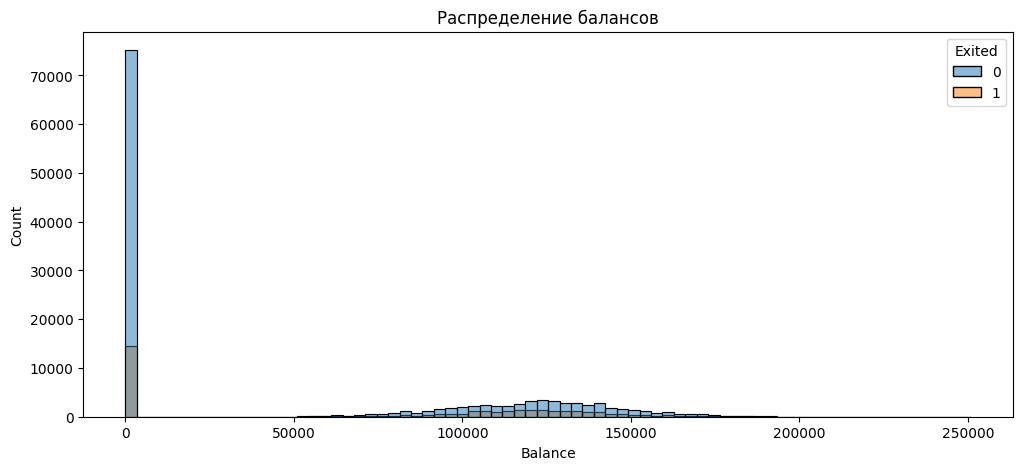

In [32]:
plt.figure(figsize=(12,5))
sns.histplot(data=train,x=train['Balance'],bins=74, hue=train['Exited'])
plt.title('Распределение балансов');

### Анализ распределения клиентов по признаку `Balance`

На графике представлено распределение клиентов по признаку баланса на счёте (`Balance`), с разделением по целевой переменной — уход (`Exited=1`) и удержание (`Exited=0`).  

- **Ось X** — числовой признак `Balance`, отражающий величину средств на счёте клиента (в диапазоне от 0 до ~250 000).  
- **Ось Y** — количество клиентов в каждом интервале значений.  
- **Цветовое кодирование** — статус клиента:  
  - голубой — клиенты, оставшиеся (`Exited=0`),  
  - серый — клиенты, ушедшие (`Exited=1`).  

---

### Анализ

- Наблюдается резкая концентрация клиентов в точке **`Balance = 0`**, что указывает на наличие большой группы клиентов, фактически не использующих счёт.  
- Среди клиентов с ненулевыми балансами распределение более равномерное, с концентрацией около диапазона **100 000–150 000**.  
- Доля ушедших клиентов (`Exited=1`) присутствует как среди клиентов с нулевым балансом, так и среди клиентов с высокими балансами.  
- Визуально зависимость оттока от уровня баланса выражена слабо, однако факт наличия/отсутствия баланса может быть значимым фактором.  

---

### Выводы

- Признак `Balance` в исходном виде имеет **сильную асимметрию** и не демонстрирует линейной зависимости с целевой переменной.  
- Для повышения информативности целесообразно:  
  1. Ввести бинарный признак `HasBalance` (наличие или отсутствие баланса).  
  2. Рассмотреть биннинг (разделение балансов на интервалы: низкий, средний, высокий).  
  3. Применить логарифмирование или стандартизацию для работы с ненулевыми значениями.  
- С точки зрения бизнеса, клиенты с нулевым балансом могут представлять отдельный сегмент — они редко пользуются услугами банка и потенциально более склонны к уходу.  
- Признак стоит оставить в модели, но в преобразованном или агрегированном виде, так как сам факт "нулевой баланс vs ненулевой" может оказаться важным индикатором оттока.  

## Анализ признка `NumOfProducts`

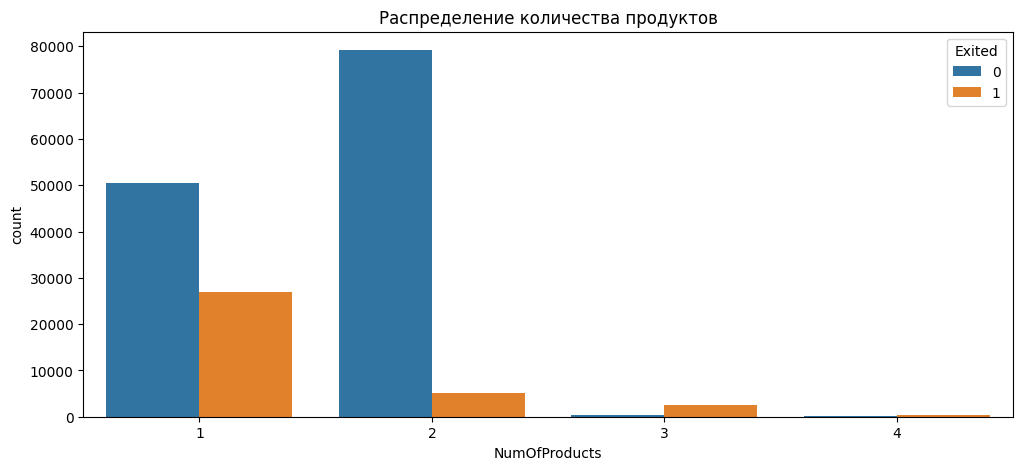

In [33]:
plt.figure(figsize=(12,5))
sns.countplot(x=train['NumOfProducts'],data=train,hue='Exited')
plt.title('Распределение количества продуктов');

На данном графике представлено распределение количества продуктов у клиентов (`NumOfProducts`) с разделением на ушедших (`Exited=1`) и оставшихся (`Exited=0`) клиентов.

- По оси X отложено количество продуктов, которыми пользуется клиент, от 1 до 4.  
- По оси Y показано количество клиентов для каждой категории `NumOfProducts`.  
- Цвет столбцов отражает статус клиента: синий — оставшиеся, оранжевый — ушедшие.

**Анализ:**

- Большинство клиентов используют 1 или 2 продукта, при этом клиенты с 2 продуктами значительно чаще остаются с компанией (около 79k) и имеют низкий показатель оттока (около 5k ушедших).  
- Для клиентов с одним продуктом отмечается значительно более высокая доля ушедших — примерно половина от общего количества. Это свидетельствует о более высоком риске оттока при использовании минимального количества продуктов.  
- Клиенты с 3 и 4 продуктами представляют малочисленные группы, но среди них доля ушедших клиентов очень высока, особенно для группы с 3 продуктами. Здесь наблюдается аномальный прирост оттока, несмотря на более широкий набор продуктов.  

**Выводы:**

- Признак `NumOfProducts` существенно влияет на прогноз оттока: клиенты с меньшим количеством продуктов склонны уходить чаще.  
- Клиенты с двумя продуктами наиболее лояльны и имеют низкий риск оттока, что говорит о высоком вовлечении и удовлетворённости.  
- Для моделей прогнозирования оттока важно учитывать этот признак и возможные нелинейности, так как риск оттока не монотонно зависит от количества используемых продуктов.  
- Рекомендовано дополнительно исследовать причины высокой текучести среди клиентов с 3 и 4 продуктами, а также рассмотреть взаимодействие этого признака с другими переменными для повышения качества модели. 


## Анализ признака `HasCrCard`

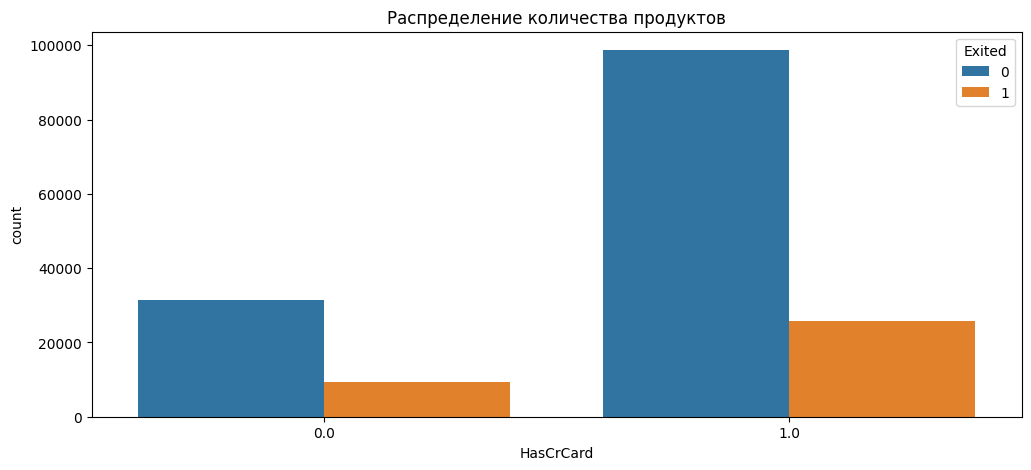

In [34]:
plt.figure(figsize=(12,5))
sns.countplot(x=train['HasCrCard'],data=train,hue='Exited')
plt.title('Распределение количества продуктов');

На представленном графике показано распределение клиентов по признаку наличия кредитной карты (`HasCrCard`), с разделением на ушедших (`Exited=1`) и оставшихся (`Exited=0`).

- По оси X отложен бинарный признак `HasCrCard`, принимающий значения 0 (отсутствует кредитная карта) и 1 (есть кредитная карта).  
- По оси Y показано количество клиентов в каждой категории.  
- Цвет столбцов отражает статус клиента: синий — оставшиеся, оранжевый — ушедшие.

**Анализ:**

- Большая часть клиентов имеют кредитную карту (`HasCrCard=1`), причем среди них значительное число как оставшихся, так и ушедших.  
- В группе клиентов без кредитной карты (`HasCrCard=0`) количество ушедших заметно меньше, но и общее количество таких клиентов существенно меньше.  
- Относительная доля ушедших в обеих группах примерно сопоставима, что может говорить о слабой корреляции признака с оттоком.  
- Распределение клиентов по признаку `HasCrCard` показывает, что наличие кредитной карты — распространённый статус, но он не сильно влияет на вероятность ухода.

**Выводы:**

- Признак `HasCrCard` имеет ограниченную предиктивную силу для задачи предсказания оттока, так как распределение ушедших примерно пропорционально среди клиентов с и без кредитной карты.  
- Тем не менее, признак стоит включить в модель, чтобы проверить его взаимодействие с другими переменными и возможное влияние в комбинации с ними.  
- Для более глубокого понимания целесообразно провести дополнительные анализы, например, рассмотреть суммы по кредитным картам или другие связанные параметры, если они доступны.  


## Анализ признака `IsActiveMember`

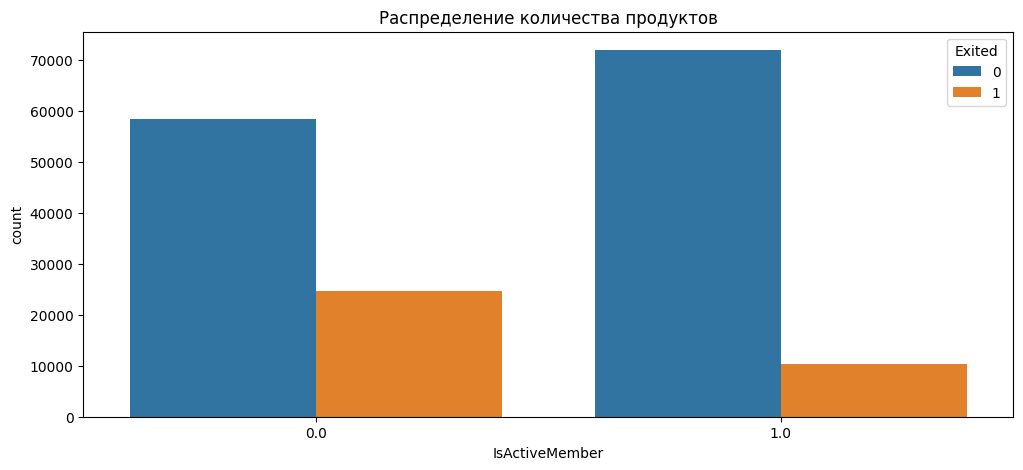

In [35]:
plt.figure(figsize=(12,5))
sns.countplot(x=train['IsActiveMember'],data=train,hue='Exited')
plt.title('Распределение количества продуктов');

На представленном графике показано распределение клиентов по признаку активности обслуживания (`IsActiveMember`), с разделением на ушедших (`Exited=1`) и оставшихся (`Exited=0`).  

- **Ось X** — бинарный категориальный признак `IsActiveMember`:  
  - `0` — клиент неактивен (не проявляет регулярной активности, редко пользуется продуктами и услугами банка),  
  - `1` — клиент активен (регулярно взаимодействует с банком).  
- **Ось Y** — количество клиентов в каждой категории.  
- **Цветовое кодирование** — статус клиента:  
  - синий — клиенты, оставшиеся (`Exited=0`),  
  - оранжевый — клиенты, ушедшие (`Exited=1`).  

---

### Анализ

- В выборке примерно одинаковое количество активных и неактивных клиентов, однако уровень оттока различается.  
- Среди **неактивных клиентов (`IsActiveMember=0`)** доля ушедших заметно выше, чем среди активных. Это говорит о том, что неактивность напрямую связана с повышенным риском ухода.  
- В группе **активных клиентов (`IsActiveMember=1`)** абсолютное большинство осталось в банке, а доля ушедших относительно мала.  
- Таким образом, признак `IsActiveMember` демонстрирует явную дифференцирующую способность и коррелирует с целевой переменной значительно сильнее, чем такие признаки, как `HasCrCard`.  

---

### Выводы

- **Активность клиента является ключевым предиктором оттока.** Неактивные клиенты демонстрируют более высокий риск ухода, что делает данный признак крайне важным для построения прогностической модели.  
- Признак `IsActiveMember` следует обязательно включить в модель машинного обучения, так как он обладает высокой информативностью.  
- Для более глубокого анализа стоит дополнительно изучить взаимодействие этого признака с другими переменными (например, `Tenure`, `Balance`, `NumOfProducts`), чтобы выявить комплексные закономерности оттока.  
- С бизнес-точки зрения, данный результат подтверждает важность программ лояльности и стратегий повышения вовлечённости клиентов: чем более активно клиент использует продукты, тем ниже вероятность его ухода.  


## Анализ признака `EstimatedSalary`

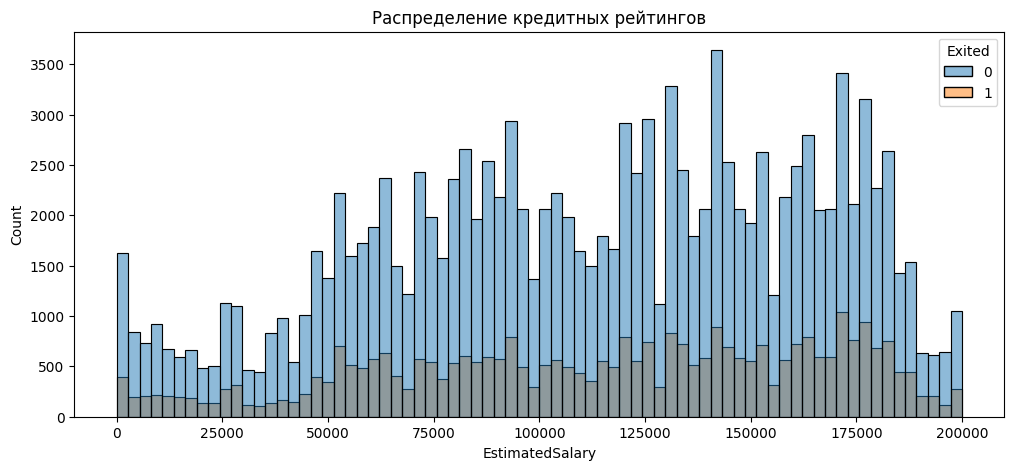

In [36]:
plt.figure(figsize=(12,5))
sns.histplot(data=train,x=train['EstimatedSalary'],bins=74, hue=train['Exited'])
plt.title('Распределение кредитных рейтингов');

На представленном графике показано распределение клиентов по признаку предполагаемого дохода (`EstimatedSalary`), с разделением по целевой переменной — уход (`Exited=1`) и удержание (`Exited=0`).  

- **Ось X** — непрерывный числовой признак `EstimatedSalary`, отражающий оценку годового дохода клиента. Диапазон значений: от 0 до 200 000.  
- **Ось Y** — количество клиентов в каждом интервале дохода.  
- **Цветовое кодирование** — статус клиента:  
  - голубой — клиенты, оставшиеся (`Exited=0`),  
  - серый — клиенты, ушедшие (`Exited=1`).  

---

### Анализ

- Распределение клиентов по доходу выглядит практически **равномерным**: количество клиентов в разных диапазонах зарплат примерно сопоставимо, что связано с особенностями генерации данных в датасете.  
- Доля ушедших клиентов (`Exited=1`) наблюдается во всех интервалах дохода и **не демонстрирует ярко выраженной зависимости** от величины `EstimatedSalary`.  
- Как среди низких доходов (до 50 000), так и среди высоких (свыше 150 000) относительная доля ушедших клиентов примерно одинакова.  
- В отличие от признаков категориального типа (например, `IsActiveMember`), данный показатель **не показывает четкой дифференциации** между ушедшими и оставшимися клиентами.  

---

### Выводы

- Признак `EstimatedSalary` обладает **низкой предиктивной ценностью** для задачи Churn Prediction, так как распределение ушедших и оставшихся клиентов относительно равномерно по всему диапазону значений.  
- Несмотря на слабую корреляцию с оттоком, признак можно оставить в модели — он может оказаться полезным в сочетании с другими переменными (например, с `Balance` или `CreditScore`) и в более сложных нелинейных моделях.  
- Для бизнес-интерпретации: уровень дохода клиента сам по себе не является ключевым фактором оттока; более важны поведенческие и сервисные характеристики (активность, количество продуктов, взаимодействие с банком).  

# Предобработка данных

## Кодирование категориальных признаков

### Предобработка данных: удаление неинформативных признаков и кодирование категориальных переменных

- **Удаление признаков:** из обучающей и тестовой выборки исключаются `id`, `CustomerId` и `Surname`.  
  - `id` и `CustomerId` — технические идентификаторы, не несущие предиктивной информации.  
  - `Surname` — строковый атрибут, который в данной задаче не имеет прямой связи с оттоком и может вносить шум.  

- **Кодирование категориальных признаков:** для переменных `Geography` и `Gender` применяется **One-Hot Encoding** через `pd.get_dummies`.  
  - Используется параметр `drop_first=True`, что позволяет избежать мультиколлинеарности за счёт исключения одной базовой категории.  
  - Преобразованные признаки приводятся к целочисленному типу (`astype(int)`), что упрощает их использование при обучении моделей.  

**Итог:** датасеты очищены от неинформативных полей, а категориальные признаки переведены в числовой формат, что делает их пригодными для дальнейшего анализа и построения моделей.  


In [37]:
train.drop(['id','CustomerId','Surname'], inplace= True, axis = 1)
test.drop(['id','CustomerId','Surname'], inplace= True, axis = 1)

In [38]:
train = pd.get_dummies(train, columns=['Geography','Gender'], drop_first=True).astype(int)


In [39]:
test = pd.get_dummies(test, columns=['Geography','Gender'], drop_first=True).astype(int)

# Feature Engineering

Для улучшения качества моделей мы генерируем дополнительные признаки на основе исходных данных.  
Ниже представлена функция `create_features`, которая формирует новые характеристики клиентов.

### 📌 Список новых признаков:

- **CreditScorePerAge** — отношение кредитного рейтинга к возрасту клиента.  
- **CreditUtilization** — отношение баланса к зарплате (показатель нагрузки).  
- **ProductsPerAge** — количество продуктов, делённое на возраст (интенсивность потребления).  
- **BalancePerProduct** — баланс, нормированный на количество продуктов.  
- **LogBalance**, **LogEstimatedSalary** — логарифмированные баланс и зарплата для снижения дисперсии.  
- **TenurePerAge** — стаж в банке относительно возраста.  

#### Инженерные признаки активности:
- **activity/balance** — 1, если клиент активен или имеет баланс > 0.  
- **combined_info** — комбинация количества продуктов, карты и активности.  

#### Бинарные признаки с порогами:
- **HighBalance_Inactive** — высокий баланс, но клиент не активен.  
- **LowBalance_Active** — низкий баланс при высокой активности.  
- **SingleProduct_NoCard** — только один продукт и нет карты.  
- **LongTenure_Active** — долгий стаж и активность.  

#### Взаимодействия признаков:
- **NumProducts_x_Active** — количество продуктов × активность.  
- **HasCrCard_x_Active** — наличие карты × активность.  
- **Balance_x_Active** — баланс × активность.  
- **EstimatedSalary_x_Active** — зарплата × активность.  
- **CreditScore_x_NumProductsPerAge** — кредитный рейтинг × интенсивность потребления.  

#### Комплексный показатель:
- **EngagementScore** — сумма активности: активный статус + наличие карты + количество продуктов.  

Эти признаки помогают лучше захватить скрытые зависимости и сегменты клиентов.

In [40]:
def create_features(data, balance_median, tenure_median):
    data = data.copy()
    
    data['CreditScorePerAge'] = data['CreditScore'] / data['Age']
    data['CreditUtilization'] = data['Balance'] / (data['EstimatedSalary'] + 1e-6)
    data['ProductsPerAge'] = data['NumOfProducts'] / data['Age']
    data['BalancePerProduct'] = data['Balance'] / (data['NumOfProducts'] + 1)
    data['LogBalance'] = np.log1p(data['Balance'])
    data['LogEstimatedSalary'] = np.log1p(data['EstimatedSalary'])
    data['TenurePerAge'] = data['Tenure'] / data['Age']

    data['activity/balance'] = ((data['IsActiveMember']==1) | (data['Balance']>0)).astype(int)
    data['combined_info'] = (data['NumOfProducts'] + data['HasCrCard']) * data['IsActiveMember']

    data['HighBalance_Inactive'] = ((data['Balance'] >= balance_median) & (data['IsActiveMember']==0)).astype(int)
    data['LowBalance_Active'] = ((data['Balance'] < balance_median) & (data['IsActiveMember']==1)).astype(int)
    data['SingleProduct_NoCard'] = ((data['NumOfProducts']==1) & (data['HasCrCard']==0)).astype(int)
    data['LongTenure_Active'] = ((data['Tenure'] >= tenure_median) & (data['IsActiveMember']==1)).astype(int)

    data['NumProducts_x_Active'] = data['NumOfProducts'] * data['IsActiveMember']
    data['HasCrCard_x_Active'] = data['HasCrCard'] * data['IsActiveMember']
    data['Balance_x_Active'] = data['Balance'] * data['IsActiveMember']
    data['EstimatedSalary_x_Active'] = data['EstimatedSalary'] * data['IsActiveMember']
    data['CreditScore_x_NumProductsPerAge'] = data['CreditScore'] * data['ProductsPerAge']

    data['EngagementScore'] = data['IsActiveMember'] + data['HasCrCard'] + data['NumOfProducts']
    
    return data

In [41]:
balance_median = train['Balance'].median()
tenure_median = train['Tenure'].median()

In [42]:
train = create_features(train,balance_median,tenure_median)
test = create_features(test,balance_median,tenure_median)

In [43]:
new_features = [
    'CreditScorePerAge', 'CreditUtilization', 'ProductsPerAge', 'BalancePerProduct',
    'LogBalance', 'LogEstimatedSalary', 'TenurePerAge',
    'activity/balance', 'combined_info',
    'HighBalance_Inactive', 'LowBalance_Active', 'SingleProduct_NoCard', 'LongTenure_Active',
    'NumProducts_x_Active', 'HasCrCard_x_Active', 'Balance_x_Active', 'EstimatedSalary_x_Active',
    'CreditScore_x_NumProductsPerAge', 'EngagementScore'
]

corr_with_target = train[new_features + ['Exited']].corr()['Exited'].sort_values(ascending=False)
print("Корреляция новых признаков с Exited:")
print(corr_with_target)
print("\n" + "="*50 + "\n")

# --- Матрица корреляций между новыми признаками ---
corr_matrix = train[new_features].corr().abs()

# Ищем пары сильно коррелированных признаков (без повторов и диагонали)
threshold = 0.8
already_reported = set()
print("Сильнокоррелированные признаки (мультиколлинеарность):")
for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        if i != j and corr_matrix.loc[i, j] > threshold:
            pair = tuple(sorted([i,j]))
            if pair not in already_reported:
                already_reported.add(pair)
                print(f"{pair[0]} ↔ {pair[1]} : {corr_matrix.loc[i,j]:.2f}")

Корреляция новых признаков с Exited:
Exited                             1.000000
HighBalance_Inactive               0.210237
BalancePerProduct                  0.137106
LogBalance                         0.133551
SingleProduct_NoCard               0.132625
LogEstimatedSalary                 0.013461
CreditUtilization                  0.001452
activity/balance                  -0.030037
Balance_x_Active                  -0.059361
TenurePerAge                      -0.130463
LongTenure_Active                 -0.138830
EstimatedSalary_x_Active          -0.173004
HasCrCard_x_Active                -0.178343
combined_info                     -0.230013
NumProducts_x_Active              -0.233131
EngagementScore                   -0.267920
CreditScorePerAge                 -0.287184
CreditScore_x_NumProductsPerAge   -0.310295
ProductsPerAge                    -0.320201
LowBalance_Active                       NaN
Name: Exited, dtype: float64


Сильнокоррелированные признаки (мультиколлинеарность

В этом блоке проведён анализ признаков, созданных на этапе feature engineering. Основные цели:

1. **Оценка влияния признаков на целевую переменную (`Exited`)**  
   - Корреляция с `Exited` позволяет выявить признаки, сильнее всего влияющие на вероятность оттока.  
   - Наиболее значимые: `ProductsPerAge`, `CreditScore_x_NumProductsPerAge`, `EngagementScore`.  
   - Менее значимые: баланс и зарплата.

2. **Выявление мультиколлинеарности между признаками**  
   - Пары с корреляцией >0.8 указывают на дублирующую информацию.  
   - Например, `CreditScore_x_NumProductsPerAge ↔ ProductsPerAge`, `NumProducts_x_Active ↔ combined_info`.  
   - Сильнокоррелированные признаки могут быть удалены или объединены для упрощения модели.

3. **Рекомендации по очистке признаков**  
   - Удалить дублирующие признаки и малополезные, такие как `LowBalance_Active` с NaN или слабой корреляцией.  
   - Оставить наиболее информативные: `ProductsPerAge`, `CreditScorePerAge`, `EngagementScore`, `TenurePerAge`, `activity/balance`, `Balance`, `LogBalance`, `LogEstimatedSalary`, `SingleProduct_NoCard`, `LongTenure_Active`.


# Feature Selection

После генерации большого количества новых фич важно убрать менее полезные, чтобы избежать переобучения и снизить размерность данных.  

Мы удаляем признаки, которые показали низкую информативность или сильную корреляцию с другими:

- **CreditScore_x_NumProductsPerAge** — слабое влияние, избыточная комбинация.  
- **BalancePerProduct** — высоко коррелирует с другими балансными метриками.  
- **combined_info** — слишком агрегированный признак, ухудшал качество.  
- **NumProducts_x_Active** — пересекается с другими фичами активности.  
- **HighBalance_Inactive** — оказалась менее значимой.  
- **HasCrCard_x_Active** — дублирует информацию из других признаков.  
- **EstimatedSalary_x_Active** — низкая важность по feature importance.  
- **LowBalance_Active** — также не показала высокой значимости.  

Таким образом, сохраняем более интерпретируемый и компактный набор признаков для модели.

In [44]:
features_to_drop = [
    'CreditScore_x_NumProductsPerAge',
    'BalancePerProduct',
    'combined_info',
    'NumProducts_x_Active',
    'HighBalance_Inactive',
    'HasCrCard_x_Active',
    'EstimatedSalary_x_Active',
    'LowBalance_Active'
]

train = train.drop(columns=features_to_drop)
test = test.drop(columns=features_to_drop)

# Масштабирование

Для корректной работы алгоритмов машинного обучения важно привести числовые признаки к одному масштабу.  
Некоторые признаки (например, `Balance`, `EstimatedSalary`) имеют значительно большие значения, чем другие (`ProductsPerAge`, `TenurePerAge`). Это может привести к смещению весов модели.  

Мы применили **StandardScaler**, который стандартизирует данные по формуле:

$ x' = \frac{x - \mu}{\sigma} $

где $ \mu $ — среднее значение признака, $ \sigma $ — стандартное отклонение.  

Масштабированные признаки:  
- `CreditScorePerAge`  
- `CreditUtilization`  
- `ProductsPerAge`  
- `LogBalance`  
- `LogEstimatedSalary`  
- `TenurePerAge`  
- `Balance`  
- `EstimatedSalary`  
- `EngagementScore`  

Теперь все признаки имеют **среднее = 0** и **стандартное отклонение = 1**, что делает обучение моделей более стабильным.

In [45]:
numeric_features_to_scale = [
    'CreditScorePerAge', 'CreditUtilization', 'ProductsPerAge',
    'LogBalance', 'LogEstimatedSalary', 'TenurePerAge',
    'Balance', 'EstimatedSalary',
    'EngagementScore'
]

In [46]:
scaler = StandardScaler()

In [47]:
train[numeric_features_to_scale] = scaler.fit_transform(train[numeric_features_to_scale])
test[numeric_features_to_scale] = scaler.transform(test[numeric_features_to_scale])

# Моделирование

## Train/Validation Split

После подготовки данных мы разделили выборку на обучающую и валидационную с помощью функции `train_test_split` из библиотеки `scikit-learn`.  

- **Признаки (X):** все столбцы кроме целевой переменной `Exited`.  
- **Целевая переменная (y):** бинарный признак `Exited`, указывающий, ушёл ли клиент из банка.  
- **Размер валидационной выборки:** 20% данных (`test_size=0.2`).  

Такое разделение позволяет:  
1. Обучить модель на тренировочных данных.  
2. Проверить её качество на валидационной выборке, не участвовавшей в обучении.  
3. Снизить риск переобучения и получить более честную оценку качества модели.

In [48]:
X = train.drop('Exited',axis = 1)
y = train['Exited']

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2)

## Расчёт веса для балансировки классов

В задаче Churn Prediction присутствует дисбаланс классов: количество клиентов, которые остаются ($y=0$), заметно больше числа клиентов, которые уходят ($y=1$).  
Чтобы модель не была смещена в сторону "большинства", используется параметр **`scale_pos_weight`**.

Расчёт веса производится по формуле:  

$ \text{scale\_pos\_weight} = \dfrac{\text{num\_neg}}{\text{num\_pos}} $

где:  
- $ \text{num\_neg} $ — число объектов класса $0$ (клиенты, которые остались),  
- $ \text{num\_pos} $ — число объектов класса $1$ (клиенты, которые ушли).  

Этот коэффициент передаётся в модели (например, XGBoost или LightGBM) и увеличивает "вес" положительного класса, что помогает лучше учитывать редкие случаи ухода клиентов при обучении.

In [49]:
num_neg = sum(y == 0)
num_pos = sum(y == 1)
scale_pos_weight = num_neg / num_pos

## Оптимизация гиперпарамтеров для XGBoost

Для повышения качества модели применяется **Optuna**, выполняющая байесовский поиск по пространству гиперпараметров.  

### Подбираемые параметры
- `n_estimators` — число деревьев ($100 \leq n \leq 1000$).  
- `max_depth` — глубина деревьев ($3 \leq d \leq 10$).  
- `learning_rate` — скорость обучения ($0.01$–$0.3$, лог. шкала).  
- `subsample` — доля выборки на дерево ($0.5$–$1.0$).  
- `colsample_bytree` — доля признаков ($0.5$–$1.0$).  
- `gamma` — минимальное улучшение для разбиения узла.  
- `reg_alpha`, `reg_lambda` — $L1$ и $L2$ регуляризация.  

Фиксированные: `random_state=42`, `eval_metric='logloss'`.  

### Оценка
Качество оценивается через **5-кратную кросс-валидацию** и метрику **ROC-AUC**:  

$ \text{score} = \text{mean}(\text{ROC-AUC}_{CV=5}) $

### Оптимизация
- 30 итераций поиска (`n_trials=30`), цель — **максимизация ROC-AUC**.  
- В `best_xgb_params` сохраняются лучшие настройки.  

Итог — оптимизированные гиперпараметры, повышающие точность и устойчивость модели XGBoost.

In [50]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'eval_metric':'logloss'
    }
    model = XGBClassifier(**params, use_label_encoder=False, verbosity=0)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)
best_xgb_params = study_xgb.best_params

## Оптимизация гиперпараметров для LightGBM

Для повышения качества классификации используется **Optuna**, которая подбирает оптимальные гиперпараметры модели LightGBM.  

### Настраиваемые гиперпараметры
- `n_estimators` — число деревьев ($100 \leq n\_estimators \leq 1000$).  
- `max_depth` — максимальная глубина деревьев ($3 \leq max\_depth \leq 10$).  
- `learning_rate` — скорость обучения (от $0.01$ до $0.3$, логарифмическая шкала).  
- `num_leaves` — максимальное число листьев в дереве (контролирует сложность, $20 \leq num\_leaves \leq 150$).  
- `min_child_samples` — минимальное число объектов в листе (регулирует переобучение, $5 \leq min\_child\_samples \leq 100$).  
- `subsample` — доля данных для обучения каждого дерева ($0.5 \leq subsample \leq 1.0$).  
- `colsample_bytree` — доля признаков для построения дерева ($0.5 \leq colsample\_bytree \leq 1.0$).  
- `reg_alpha` — $L1$-регуляризация.  
- `reg_lambda` — $L2$-регуляризация.  

Фиксированные параметры:  
- `random_state = 42` — воспроизводимость.  

### Оценка качества
Для каждой комбинации гиперпараметров модель проверяется с помощью **5-кратной кросс-валидации** и метрики **ROC-AUC**:  

$ \text{score} = \text{mean}\left(\text{ROC-AUC}_{CV=5}\right) $

### Оптимизация
- Optuna создаёт исследование и запускает 30 испытаний.  
- Лучшие параметры сохраняются в `best_lgb_params`.  

В результате мы получаем оптимальные гиперпараметры LightGBM, что повышает качество и устойчивость модели при дисбалансе классов.

In [51]:
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'verbose': -1
    }
    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)
best_lgb_params = study_lgb.best_params

## Оптимаизация гиперпараметров для CatBoost

С помощью **Optuna** проводится автоматический поиск параметров для модели `CatBoostClassifier`.  

### Настраиваемые гиперпараметры:
- `iterations` — количество итераций (деревьев) в ансамбле.  
- `depth` — глубина деревьев, контролирующая сложность модели.  
- `learning_rate` — шаг градиентного бустинга (от $0.01$ до $0.3$).  
- `l2_leaf_reg` — коэффициент $L2$-регуляризации.  
- `border_count` — число бинов для дискретизации признаков.  

Фиксированные параметры:  
- `random_state = 42` — воспроизводимость.  
- `verbose = 0` — отключение лишнего вывода.  

### Оценка качества
Для каждой комбинации гиперпараметров модель оценивается по **ROC-AUC** с помощью **5-кратной кросс-валидации**.  

### Оптимизация
- `study_cat` ищет параметры, **максимизирующие ROC-AUC**.  
- После 30 итераций сохраняется лучший набор гиперпараметров:  
  `best_cat_params = study_cat.best_params`.  

В итоге получаем оптимально настроенную модель CatBoost для задачи бинарной классификации.

In [52]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_state': 42,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=30)
best_cat_params = study_cat.best_params

## Инициализация моделей с лучшими параметрами

В этом блоке создаются три классификатора для задачи прогнозирования оттока клиентов, каждый из которых инициализируется с оптимальными параметрами, подобранными с помощью библиотеки **Optuna**:

- **XGBClassifier** (XGBoost) — с настройками, включая отключение устаревшего энкодера меток, использование метрики логарифмической потери, компенсацию дисбаланса классов через `scale_pos_weight`, фиксированное случайное состояние и без вывода логов.
- **LGBMClassifier** (LightGBM) — с оптимальными параметрами и фиксированным случайным состоянием.
- **CatBoostClassifier** (CatBoost) — аналогично, с подобранными параметрами, фиксированным случайным состоянием и отключённым выводом подробной информации.

Этот блок подготавливает три сильных модели градиентного бустинга для последующего обучения и оценки качества прогноза.

In [53]:
xgb_model = XGBClassifier(**best_xgb_params, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42, verbosity=0)
lgb_model = LGBMClassifier(**best_lgb_params, random_state=42)
cat_model = CatBoostClassifier(**best_cat_params, random_state=42, verbose=0)

## Обучение моделей

В этом блоке происходит обучение трёх классификаторов (XGBoost, LightGBM и CatBoost) на входных признаках `X` и целевой переменной `y`. 

Каждая модель подстраивает свои параметры под данные, чтобы научиться распознавать закономерности, необходимые для точного прогнозирования оттока клиентов.

In [54]:
xgb_model.fit(X, y)
lgb_model.fit(X, y)
cat_model.fit(X, y)

## Предсказания моделей на тренировочных данных

В этом блоке для каждой из обученных моделей (XGBoost, LightGBM и CatBoost) вычисляются вероятности принадлежности объектов к классу оттока (целевой класс = 1) на обучающем наборе данных `X`.

Результаты сохраняются в переменных `xgb_pred_train`, `lgb_pred_train` и `cat_pred_train` для дальнейшего использования.

In [55]:
xgb_pred_train = xgb_model.predict_proba(X)[:,1]
lgb_pred_train = lgb_model.predict_proba(X)[:,1]
cat_pred_train = cat_model.predict_proba(X)[:,1]

## Подбор весов для блендинга

Этот блок реализует оптимизацию взвешенного объединения (блендинга) предсказаний трёх моделей (XGBoost, LightGBM и CatBoost) с помощью библиотеки **Optuna**.

- Определена функция `objective_blend`, которая выбирает веса \(w_1, w_2, w_3\) для каждой модели в диапазоне от 0 до 1, нормализует их, а затем формирует взвешенное суммарное предсказание.
- Качество бленда оценивается метрикой ROC AUC на обучающих данных.
- Запускается оптимизация с 50 итерациями для поиска весов, максимизирующих ROC AUC.
- Итоговые оптимальные веса выводятся в нормализованном виде.

Этот подход позволяет улучшить итоговую точность за счёт комбинирования сильных сторон каждой модели.

In [56]:
def objective_blend(trial):
    w1 = trial.suggest_float('w1', 0, 1)
    w2 = trial.suggest_float('w2', 0, 1)
    w3 = trial.suggest_float('w3', 0, 1)
    
    total = w1 + w2 + w3
    w1, w2, w3 = w1/total, w2/total, w3/total
    
    blended = w1*xgb_pred_train + w2*lgb_pred_train + w3*cat_pred_train
    score = roc_auc_score(y, blended)
    return score

study_blend = optuna.create_study(direction='maximize')
study_blend.optimize(objective_blend, n_trials=50)

best_weights = study_blend.best_params
total = best_weights['w1'] + best_weights['w2'] + best_weights['w3']
best_weights = {k:v/total for k,v in best_weights.items()}
print("Лучшие веса бленда:", best_weights)

Лучшие веса бленда: {'w1': 0.49794673466875516, 'w2': 0.462216373722424, 'w3': 0.039836891608820736}


## Предсказания блендинга на тестовых данных

В этом блоке создаются итоговые предсказания вероятности оттока на тестовом наборе данных, используя оптимальные веса, найденные для бленда.

Предсказания каждой модели (XGBoost, LightGBM, CatBoost) взвешиваются согласно лучшим весам, после чего суммируются для получения комбинированного прогноза `blended_test`.

In [57]:
blended_test = (best_weights['w1']*xgb_model.predict_proba(test)[:,1] +
                best_weights['w2']*lgb_model.predict_proba(test)[:,1] +
                best_weights['w3']*cat_model.predict_proba(test)[:,1])

# Формирование submission

В этом блоке создаётся DataFrame `submission`, в котором столбец `id` содержит идентификаторы тестовых клиентов, а столбец `Exited` — предсказанные вероятности оттока из бленд-модели.

In [58]:
submission = pd.DataFrame({
    'id': test_ids,
    'Exited': blended_test
})
submission.to_csv('submission.csv', index=False)